#**Categorical and Temporal Variable Integration for GSMaP Daily Rainfall Calibration using XGBoost: BMKG Bandung Case Study** <br>

Written by: Iqbal Fauzan Herlambang<br>
Date: 8 May 2025

**Abstract:** <br>
This research presents an effective satellite rainfall calibration method using XGBoost to improve daily GSMaP precipitation estimates at BMKG Climatology Station Bandung, Indonesia. The study utilized historical daily rainfall data from 2020-2024 for model development and testing, with 80% used for training and 20% for testing. The model demonstrates significant enhancement in rainfall data accuracy after applying the correction model, as evidenced by the validation results using unseen data from January-April 2025, where the RMSE decreased from 18.77 to 8.87 mm, MAE reduced from 11.96 to 3.66 mm, and correlation coefficient substantially improved from 0.014 to 0.754. Feature importance analysis revealed that Correction Type (87.13%) and Rainfall Intensity Category (8.47%) were the most influential variables in the calibration process, while temporal variables contributed minimally. The scatter plot visualization confirms the correction effectiveness, showing improved alignment of satellite data with ground station measurements after calibration, thus providing more reliable precipitation information for meteorological applications in the region.
<br>


_**keywords**: rainfall, calibration, ground station, satellite data, machine learning, xgboost_<br>

Notes:<br>
1. RR = Rainfall for BMKG
2. GSMaP = Rainfall for GSMaP

## **Importing Modules**

In [1296]:
# Import Module Set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## **Chapter 1<br> Data Preparation**

### **A. Import Dataset** <br>

In [1240]:
# Import Data BMKG
raw_bmkg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/BMKG Klimatologi Bandung 2020-2024.csv')
print(raw_bmkg.info())
# Import Data GSMaP Satellite
raw_gsmap = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/GSMaP 2020-2024 Rainfall Data.csv')
print(raw_gsmap.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1827 non-null   object
 1   RR      1821 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1827 non-null   object 
 1   dailyPrecipRate  1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB
None


In [1282]:
# Change the date format to 'yyyy-mm-dd'
raw_bmkg['DATE'] = pd.to_datetime(raw_bmkg['DATE'])
raw_gsmap['date'] = pd.to_datetime(raw_gsmap['date'])

### **B. Data Cleaning**

#### 1. Clearing & Imputation of BMKG Data

In [1287]:
clean_bmkg = raw_bmkg.copy()

# Replace non-numeric values with NaN
clean_bmkg['RR'] = pd.to_numeric(clean_bmkg['RR'], errors='coerce')

print(clean_bmkg.info())
clean_bmkg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1827 non-null   datetime64[ns]
 1   RR      1594 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB
None


,DATE,RR
0,2020-01-01,13.4
1,2020-01-02,2.2
2,2020-01-03,8888.0
3,2020-01-04,0.0
4,2020-01-05,0.0
...,...,...
1822,2024-12-27,0.0
1823,2024-12-28,1.5
1824,2024-12-29,0.1
1825,2024-12-30,0.0


In [1288]:
# Replace '8888', '9999', and '-' with NaN
clean_bmkg['RR'] = clean_bmkg['RR'].replace([8888, 9999,"-"], np.nan)

# Apply a moving average (MA) 7 to fill NaN values
clean_bmkg['RR'] = clean_bmkg['RR'].fillna(clean_bmkg['RR'].rolling(window=7, min_periods=1).mean())
clean_bmkg['RR'] = clean_bmkg['RR'].fillna(clean_bmkg['RR'].rolling(window=7, min_periods=1).mean())

print(clean_bmkg.info())
clean_bmkg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1827 non-null   datetime64[ns]
 1   RR      1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB
None


,DATE,RR
0,2020-01-01,13.40
1,2020-01-02,2.20
2,2020-01-03,7.80
3,2020-01-04,0.00
4,2020-01-05,0.00
...,...,...
1822,2024-12-27,0.00
1823,2024-12-28,1.50
1824,2024-12-29,0.10
1825,2024-12-30,0.00


#### 2. Cleaning GSMaP Data

In [1289]:
clean_gsmap = raw_gsmap.copy()

clean_gsmap.info()
# Data is already cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1827 non-null   datetime64[ns]
 1   dailyPrecipRate  1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


## **Chapter 2<br> Data Preprocessing**

### **A. Adding Generative Variables**

Add other variables to add depth/dimension to the overall dataset. In this case I added Laging Rainfall Day,Day_of_Year, Correction Type Label, Correction Factor, RR Intensity Rainfall Category.

In [1290]:
# Combine all raw (cleaned) dataset
df = pd.merge(clean_bmkg,clean_gsmap, left_on = 'DATE', right_on = 'date', how = 'inner')
df = df.drop(columns=['date'])
df = df.rename(columns={'dailyPrecipRate':'GSMaP'})
df

,DATE,RR,GSMaP
0,2020-01-01,13.40,17.03
1,2020-01-02,2.20,0.79
2,2020-01-03,7.80,0.96
3,2020-01-04,0.00,2.12
4,2020-01-05,0.00,24.35
...,...,...,...
1822,2024-12-27,0.00,5.53
1823,2024-12-28,1.50,5.57
1824,2024-12-29,0.10,3.34
1825,2024-12-30,0.00,0.09


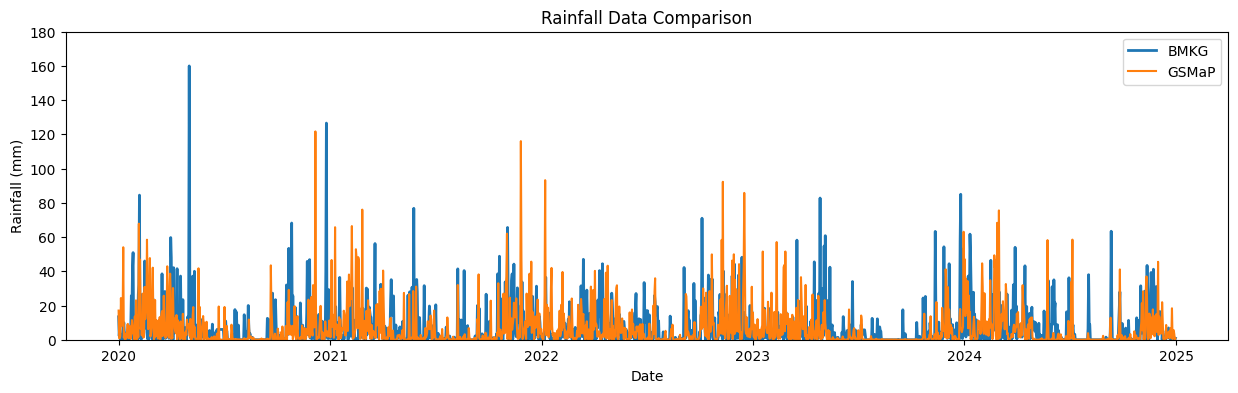

In [1295]:
plt.figure(figsize=(15,4))
plt.plot(df['DATE'], df['RR'], label='BMKG',linewidth=2)
plt.plot(df['DATE'], df['GSMaP'], label='GSMaP')

plt.title('Rainfall Data Comparison')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,180)
plt.legend()
plt.show()

In [1246]:
# Adding Other Variables from GSMaP Based Data
def add_features (df):

  # ===== Temporal Variable =====
  df['GSMaP_lag1'] = df['GSMaP'].shift(1).fillna(0)
  df['Day_of_Year'] = df['DATE'].dt.dayofyear

  # ==== Correction Type Label ====
  max_normal = 20 # correction factor
  min_threshold = 0.5 # mm
  # Case 1: Normal - both detect significant amounts of rain
  normal_mask = (df['GSMaP'] >= min_threshold) & (df['RR'] >= min_threshold)
  # Case 2: GSMaP missed rain - GSMaP not/very small, but RR detected
  missed_rain_mask = (df['GSMaP'] < min_threshold) & (df['RR'] >= min_threshold)
  # Case 3: GSMaP false alarm - GSMaP detects rain, but very little/no RR
  false_alarm_mask = (df['GSMaP'] >= min_threshold) & (df['RR'] < min_threshold)
  # Case 4: Both do not detect rain
  no_rain_mask = (df['GSMaP'] < min_threshold) & (df['RR'] < min_threshold)

  # Calculate the correction factor for each case
  # Case 1
  df.loc[normal_mask, 'Correction_Factor'] = df.loc[normal_mask, 'RR'] / df.loc[normal_mask, 'GSMaP']
  # Case 2
  df.loc[missed_rain_mask, 'Correction_Factor'] = max_normal
  # Case 3
  df.loc[false_alarm_mask, 'Correction_Factor'] = df.loc[false_alarm_mask, 'RR'] / df.loc[false_alarm_mask, 'GSMaP']
  # Case 4
  df.loc[no_rain_mask, 'Correction_Factor'] = 1

  # Limit outlier values
  # Clip normal values to avoid extreme outliers
  df.loc[normal_mask, 'Correction_Factor'] = np.clip(df.loc[normal_mask, 'Correction_Factor'], 0, max_normal)
  # Clip the false alarm value to avoid outliers close to zero
  df.loc[false_alarm_mask, 'Correction_Factor'] = np.clip(df.loc[false_alarm_mask, 'Correction_Factor'], 0.1, 1.0)

  # Add correction type label as an additional feature
  df['Correction_Type'] = 0  # default: normal
  df.loc[missed_rain_mask, 'Correction_Type'] = 1  # missed rain
  df.loc[false_alarm_mask, 'Correction_Type'] = 2  # false alarm
  df.loc[no_rain_mask, 'Correction_Type'] = 3  # no rain

  # ==== FITUR BERBASIS INTENSITAS HUJAN ====

  # Kategorisasi intensitas hujan GSMaP
  intensity_bins = [0, 5, 20, 50, 100, float('inf')]
  intensity_labels = [0, 1, 2, 3, 4]  # 0=No/light rain, 4=Extreme
  df['RR_Intensity_Cat'] = pd.cut(df['RR'], bins=intensity_bins, labels=intensity_labels).fillna(0)

  df = df.round(2)
  return df

add_features(df)

,DATE,RR,GSMaP,GSMaP_lag1,Day_of_Year,Correction_Factor,Correction_Type,RR_Intensity_Cat
0,2020-01-01,13.40,17.03,0.00,1,0.79,0,1
1,2020-01-02,2.20,0.79,17.03,2,2.78,0,0
2,2020-01-03,7.80,0.96,0.79,3,8.13,0,1
3,2020-01-04,0.00,2.12,0.96,4,0.10,2,0
4,2020-01-05,0.00,24.35,2.12,5,0.10,2,0
...,...,...,...,...,...,...,...,...
1822,2024-12-27,0.00,5.53,0.39,362,0.10,2,0
1823,2024-12-28,1.50,5.57,5.53,363,0.27,0,0
1824,2024-12-29,0.10,3.34,5.57,364,0.10,2,0
1825,2024-12-30,0.00,0.09,3.34,365,1.00,3,0


 ### **B. Exploratory Data Analysis (EDA)** <br>

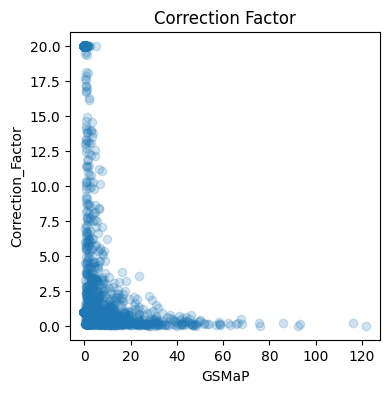

In [1247]:
plt.figure(figsize=(4,4))
plt.scatter(df['GSMaP'], df['Correction_Factor'], alpha=0.2,)
plt.title('Correction Factor')
plt.xlabel('GSMaP')
plt.ylabel('Correction_Factor')
plt.show()

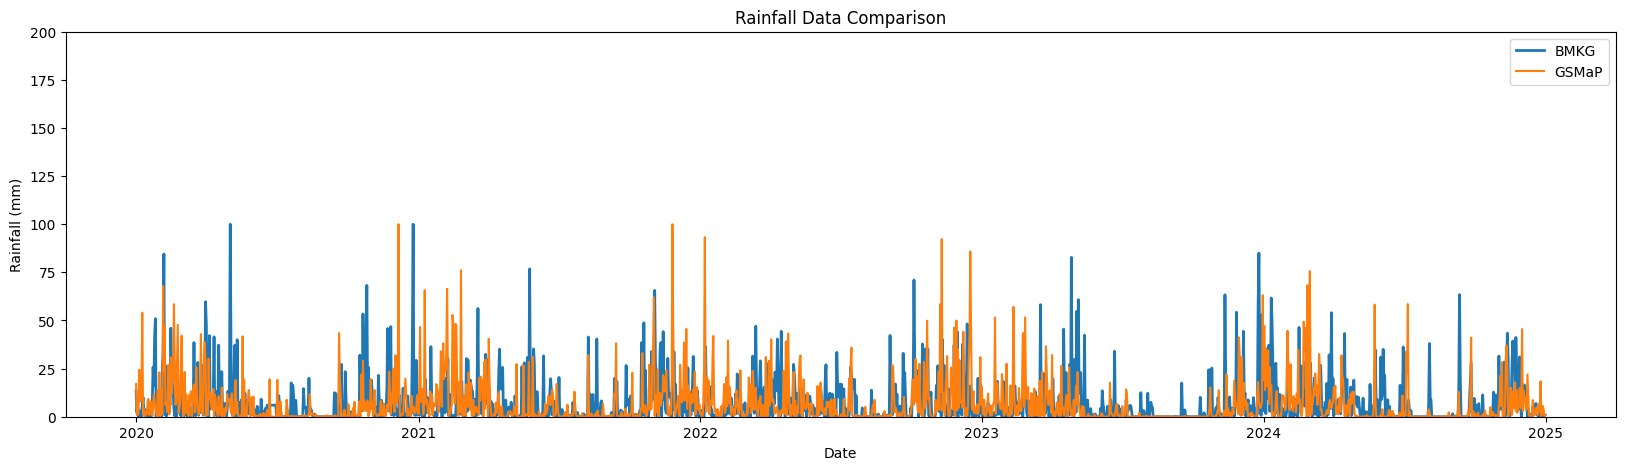

In [1281]:
plt.figure(figsize=(20,5))
plt.plot(df['DATE'], df['RR'], label='BMKG',linewidth=2)
plt.plot(df['DATE'], df['GSMaP'], label='GSMaP')

plt.title('Rainfall Data Comparison')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,200)
plt.legend()
plt.show()

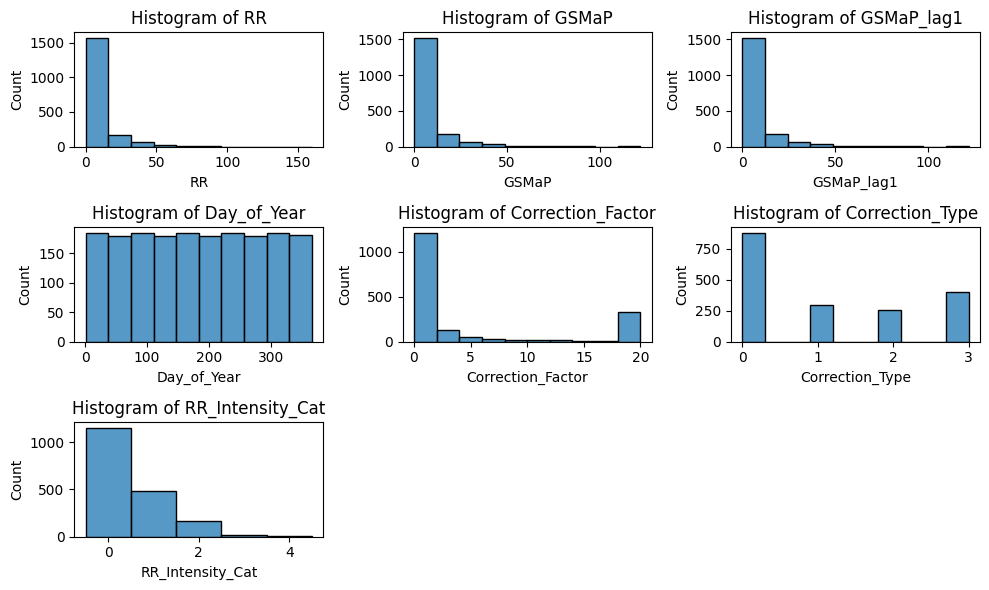

In [1249]:
#df_no_date = df.drop(columns=['DATE','Day_of_Year','month'])
df_no_date = df.drop(columns=['DATE'])
num_features = len(df_no_date.columns)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 2 * num_rows))

for i, column in enumerate(df_no_date.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(df[column], bins=10, ax=axes[row, col])
    axes[row, col].set_title(f"Histogram of {column}")

# Turn off any unused subplots
for i in range(num_features, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

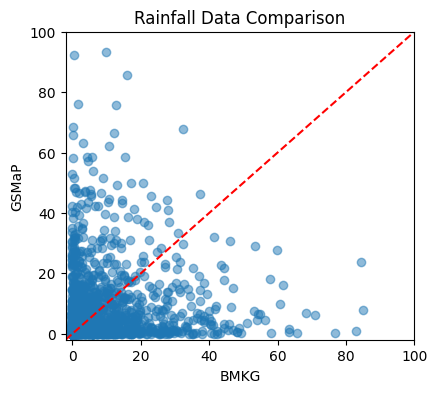

In [1250]:
plt.figure(figsize=(4.5,4))
plt.scatter(df['RR'], df['GSMaP'], alpha=0.5,)
plt.plot([-2, 200], [-2, 200], color='red', linestyle='--')
plt.title('Rainfall Data Comparison')
plt.xlabel('BMKG')
plt.ylabel('GSMaP')
plt.xlim(-2,100)
plt.ylim(-2,100)
plt.show()

In [1251]:
df.describe()

,DATE,RR,GSMaP,GSMaP_lag1,Day_of_Year,Correction_Factor,Correction_Type
count,1827,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,2022-07-02 00:00:00.000000256,7.164901,6.554362,6.553963,183.200328,4.995614,1.095785
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000,0.005418,0.000000
25%,2021-04-01 12:00:00,0.000000,0.090000,0.090000,92.000000,0.330430,0.000000
50%,2022-07-02 00:00:00,2.220000,1.530000,1.530000,183.000000,1.000000,1.000000
75%,2023-10-01 12:00:00,9.308333,7.935000,7.935000,274.500000,5.302977,2.000000
max,2024-12-31 00:00:00,160.000000,121.730000,121.730000,366.000000,20.000000,3.000000
std,NaN,12.151433,11.779617,11.779827,105.510948,7.500866,1.218747


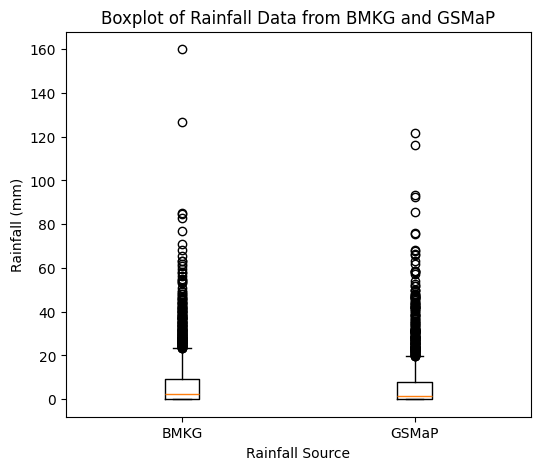

In [1252]:
plt.figure(figsize=(6,5))
plt.boxplot([df['RR'], df['GSMaP']])
plt.xticks([1, 2], ['BMKG', 'GSMaP']) # adding labels
plt.xlabel('Rainfall Source')
plt.ylabel('Rainfall (mm)')
plt.title('Boxplot of Rainfall Data from BMKG and GSMaP')
plt.show()

In [1253]:
df.loc[df['GSMaP'] > 100, 'GSMaP'] = 100
df.loc[df['RR'] > 100, 'RR'] = 100

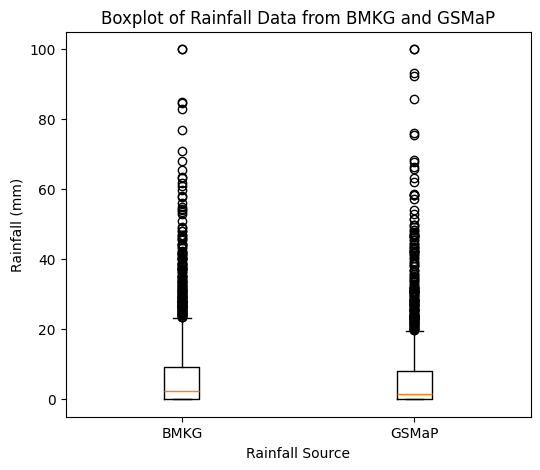

In [1254]:
plt.figure(figsize=(6,5))
plt.boxplot([df['RR'], df['GSMaP']])
plt.xticks([1, 2], ['BMKG', 'GSMaP']) # adding labels
plt.xlabel('Rainfall Source')
plt.ylabel('Rainfall (mm)')
plt.title('Boxplot of Rainfall Data from BMKG and GSMaP')
plt.show()

## **Chapter 3<br>Modeling**

### **A. Scaling Data using Min Max Scaler & Splitting Target-Features**

In [1255]:
df_scale = df.copy()

x = df_scale.drop(columns=['RR','DATE','Correction_Factor'])
y = df_scale['Correction_Factor'].drop(columns=['DATE'])
date = df_scale['DATE']

gsmap = df_scale['GSMaP']

scaler = MinMaxScaler()
columns_to_scale = ['GSMaP','GSMaP_lag1','Day_of_Year','month','Correction_Factor','Correction_Type','RR_Intensity_Cat']

x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y_scaled = pd.DataFrame(y_scaled, columns=['Correction_Factor'])

### **B. Train Test Splitting**

In [1256]:
# Combination of 80% Training and 20% Testing
x_train,x_test, y_train,y_test,date_train,date_test = train_test_split(x_scaled,y_scaled,date,test_size=0.2,random_state=42,shuffle=True)

### **C. Model Regression: XG Boost Regressor**

In [1257]:
# XGBoost Regression

model_xgb = XGBRegressor(n_estimators=20,booster='gbtree',max_features='sqrt',max_depth=10,random_state=42)
model_xgb.fit(x_train, y_train)

y_pred_xgb = model_xgb.predict(x_test)

# Inverse transform the scaled prediction to get the original scale
y_pred_xgb_original_scale = scaler.inverse_transform(np.concatenate([y_pred_xgb.reshape(-1,1), x_test], axis=1))[:, 0]

#Similarly, inverse transform y_test
y_test_original_scale = scaler.inverse_transform(y_test)

#Now you can use y_pred_xgb_original_scale and y_test_original_scale for evaluation metrics
rmse_xgb = np.round(root_mean_squared_error(y_test_original_scale, y_pred_xgb_original_scale),3)
mae_xgb = np.round(mean_absolute_error(y_test_original_scale,y_pred_xgb_original_scale),3)
r2_xgb = np.round(r2_score(y_test_original_scale,y_pred_xgb_original_scale),3)
correlation = np.round(np.corrcoef(y_test_original_scale.ravel(),y_pred_xgb_original_scale)[0, 1],3)


print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R-squared: {r2_xgb}")
print(f"Correlation: {correlation}")

RMSE: 1.203
MAE: 0.461
R-squared: 0.975
Correlation: 0.987


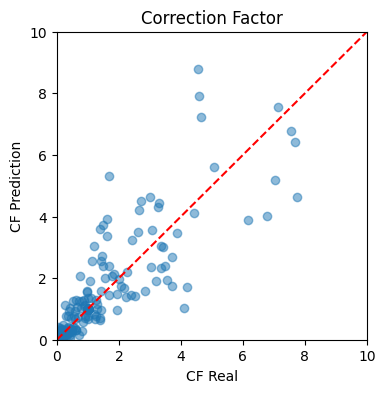

In [1258]:
plt.figure(figsize=(4,4))
plt.scatter(y_test_original_scale, y_pred_xgb_original_scale, alpha=0.5)
plt.plot([0, 15], [0, 15], color='red', linestyle='--')
plt.title('Correction Factor')
plt.xlabel('CF Real')
plt.ylabel('CF Prediction')
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

In [1259]:
feature_importances = model_xgb.feature_importances_
print("Feature Importances RF:")
for i, feature_name in enumerate(x.columns):
    print(f"{feature_name}: {np.round(feature_importances[i]*100.0,2)} %")

Feature Importances RF:
GSMaP: 4.25 %
GSMaP_lag1: 0.07000000029802322 %
Day_of_Year: 0.07999999821186066 %
Correction_Type: 87.12999725341797 %
RR_Intensity_Cat: 8.470000267028809 %


In [1260]:
# Multiply y_pred_xgb_original_scale with GSMaP values from the test set
rainfall_pred = np.abs(y_pred_xgb_original_scale * df.loc[date_test.index, 'GSMaP'].values)

rainfall_test = df.loc[date_test.index, 'GSMaP'].values

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Date': date_test.values,  # Assuming date_test is a Series or array-like
    'GSMaP': rainfall_test,
    'BMKG': df.loc[date_test.index, 'RR'].values,
    'Predicted_Rainfall': rainfall_pred
}).sort_values(by='Date').reset_index(drop=True)


# Example usage for evaluation:
rmse_multiplied = np.round(root_mean_squared_error(rainfall_test, rainfall_pred), 3)
mae_multiplied = np.round(mean_absolute_error(rainfall_test, rainfall_pred), 3)
r2_multiplied = np.round(r2_score(rainfall_test, rainfall_pred), 3)

print(f"Test Dataset RMSE: {rmse_multiplied}")
print(f"Test Dataset MAE: {mae_multiplied}")
print(f"Test Dataset R-squared: {r2_multiplied}")

results_df.round(2)

Test Dataset RMSE: 11.907
Test Dataset MAE: 6.274
Test Dataset R-squared: -0.347


,Date,GSMaP,BMKG,Predicted_Rainfall
0,2020-01-24,11.47,16.00,8.27
1,2020-01-30,0.09,3.40,1.80
2,2020-01-31,23.01,0.00,2.01
3,2020-02-02,0.36,5.00,7.19
4,2020-02-14,4.27,6.20,11.62
...,...,...,...,...
361,2024-12-19,4.30,6.90,16.90
362,2024-12-20,4.87,1.00,2.35
363,2024-12-21,0.87,3.23,1.53
364,2024-12-23,6.83,0.00,0.92


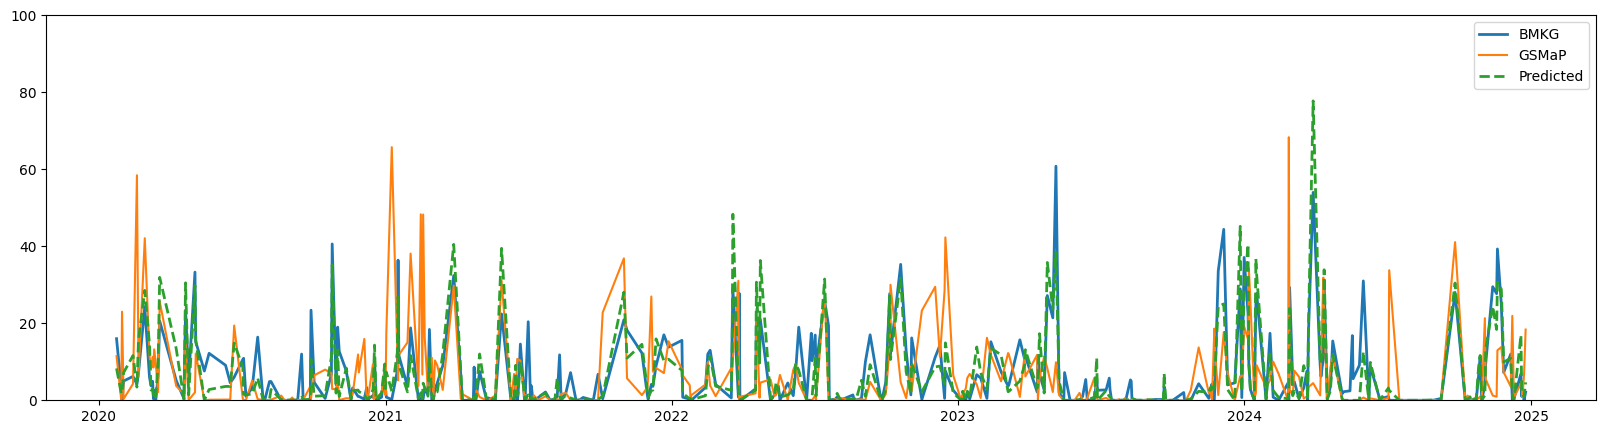

In [1261]:
plt.figure(figsize=(20,5))
plt.plot(results_df['Date'], results_df['BMKG'], label='BMKG',linewidth=2)
plt.plot(results_df['Date'], results_df['GSMaP'], label='GSMaP')
plt.plot(results_df['Date'], results_df['Predicted_Rainfall'], label='Predicted',linewidth=2,linestyle='--')
plt.ylim(0,100)
plt.legend()
plt.show()

## **Chapter 4<br>Evaluation**

### **A. Hyperparameter Tuning - GridSearchCV**

In [1262]:
# Definition grid parameter for hyperparameter tuning
param_grid = {
    'n_estimators': [5, 10, 20, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

In [1263]:
grid_search = GridSearchCV(model_xgb, param_grid,cv=10,scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [1264]:
print(best_params)
print(best_model)

{'learning_rate': 0.2, 'n_estimators': 50}
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_features='sqrt',
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)


### **B. Applying the Best Parameters back to XGBoost** <br>

In [1265]:
model_xgb_best = XGBRegressor(**best_params, random_state=42) # Use **best_params to unpack the dictionary
model_xgb_best.fit(x_train, y_train)

y_pred_xgb_best = model_xgb_best.predict(x_test)

# Inverse transform the scaled prediction
y_pred_xgb_best_original_scale = scaler.inverse_transform(np.concatenate([y_pred_xgb_best.reshape(-1,1), x_test], axis=1))[:, 0]

rmse_xgb_best = np.round(root_mean_squared_error(y_test_original_scale, y_pred_xgb_best_original_scale),3)
mae_xgb_best = np.round(mean_absolute_error(y_test_original_scale,y_pred_xgb_best_original_scale),3)
r2_xgb_best = np.round(r2_score(y_test_original_scale,y_pred_xgb_best_original_scale),3)
correlation = np.round(np.corrcoef(y_test_original_scale.ravel(),y_pred_xgb_best_original_scale)[0, 1],3)

print(f"Best Model - RMSE: {rmse_xgb_best}")
print(f"Best Model - MAE: {mae_xgb_best}")
print(f"Best Model - R-squared: {r2_xgb_best}")
print(f"Correlation: {correlation}")

Best Model - RMSE: 0.999
Best Model - MAE: 0.429
Best Model - R-squared: 0.983
Correlation: 0.991


### **C. Evaluation After Tuning**

In [1266]:
# Multiply y_pred_xgb_original_scale with GSMaP values from the test set
rainfall_pred = np.abs(y_pred_xgb_best_original_scale * df.loc[date_test.index, 'GSMaP'].values)

rainfall_test = df.loc[date_test.index, 'GSMaP'].values

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Date': date_test.values,  # Assuming date_test is a Series or array-like
    'GSMaP': rainfall_test,
    'BMKG': df.loc[date_test.index, 'RR'].values,
    'Predicted_Rainfall': rainfall_pred
}).sort_values(by='Date').reset_index(drop=True)


# Example usage for evaluation:
rmse_multiplied = np.round(root_mean_squared_error(rainfall_test, rainfall_pred), 3)
mae_multiplied = np.round(mean_absolute_error(rainfall_test, rainfall_pred), 3)
r2_multiplied = np.round(r2_score(rainfall_test, rainfall_pred), 3)
correlation_multiplied = np.round(np.corrcoef(rainfall_test, rainfall_pred)[0, 1],3)

print(f"Test Dataset RMSE: {rmse_multiplied}")
print(f"Test Dataset MAE: {mae_multiplied}")
print(f"Test Dataset R-squared: {r2_multiplied}")
print(f"Correlation: {correlation_multiplied}")

results_df.round(2)

Test Dataset RMSE: 11.778
Test Dataset MAE: 6.215
Test Dataset R-squared: -0.318
Correlation: 0.321


,Date,GSMaP,BMKG,Predicted_Rainfall
0,2020-01-24,11.47,16.00,7.73
1,2020-01-30,0.09,3.40,1.80
2,2020-01-31,23.01,0.00,1.61
3,2020-02-02,0.36,5.00,7.20
4,2020-02-14,4.27,6.20,12.08
...,...,...,...,...
361,2024-12-19,4.30,6.90,14.79
362,2024-12-20,4.87,1.00,2.76
363,2024-12-21,0.87,3.23,2.03
364,2024-12-23,6.83,0.00,0.94


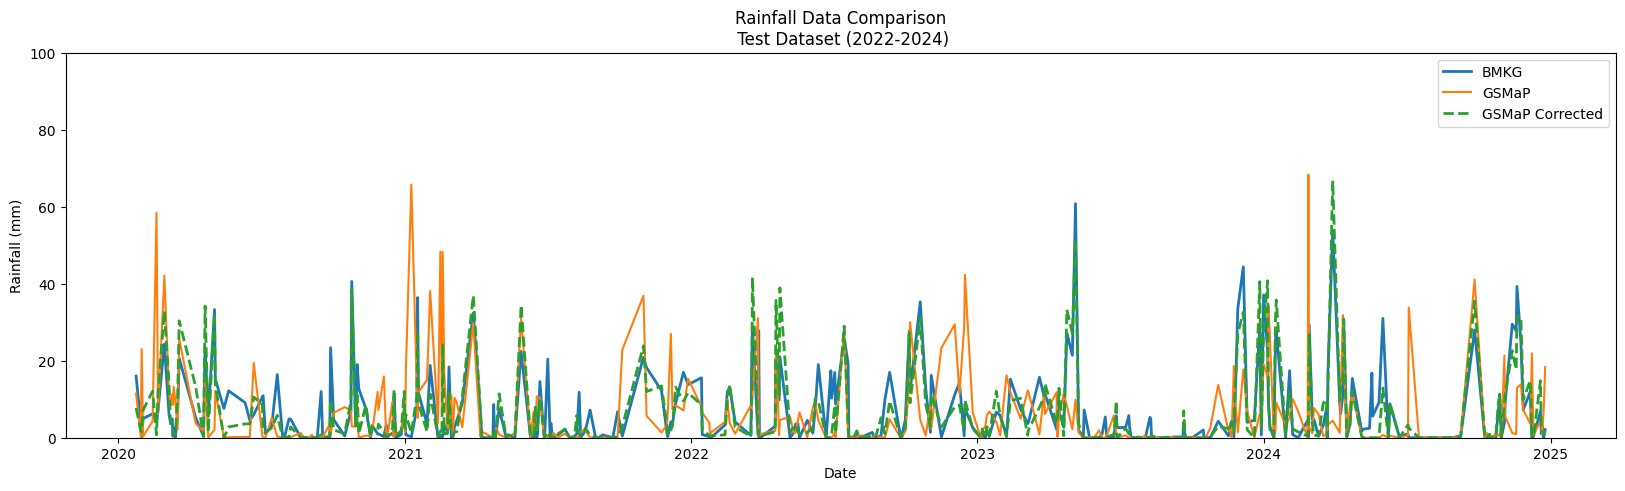

In [1267]:
plt.figure(figsize=(20,5))
plt.plot(results_df['Date'], results_df['BMKG'], label='BMKG',linewidth=2)
plt.plot(results_df['Date'], results_df['GSMaP'], label='GSMaP')
plt.plot(results_df['Date'], results_df['Predicted_Rainfall'], label='GSMaP Corrected',linewidth=2,linestyle='--')
plt.title('Rainfall Data Comparison\n Test Dataset (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,100)
plt.legend()
plt.show()

### Additional : Try to Use Model to Overall Dataset (2022-2024)

In [1268]:
df_all = df.copy()

x_all = df_all.drop(columns=['RR','DATE','Correction_Factor'])
y_all = df_all['Correction_Factor'].drop(columns=['DATE'])

x_scaled_all = scaler.fit_transform(x_all)
x_scaled_all = pd.DataFrame(x_scaled_all, columns=x_all.columns)

y_scaled_all = scaler.fit_transform(y_all.values.reshape(-1, 1))
y_scaled_all = pd.DataFrame(y_scaled_all, columns=['Correction_Factor'])

In [1269]:
# Random Forest Regression

y_pred_xgb_all = model_xgb.predict(x_scaled_all)

y_pred_xgb_all_original_scale = scaler.inverse_transform(np.concatenate([y_pred_xgb_all.reshape(-1,1), x_scaled_all], axis=1))[:, 0]
df_all['Correction Factor Model'] = y_pred_xgb_all_original_scale.round(2)
df_all['Corrected Rainfall'] = df_all['GSMaP'] * df_all['Correction Factor Model'].round(2)
df_all['Corrected Rainfall'] = df_all['Corrected Rainfall'].clip(lower=0)

df_all = df_all.round(2)
df_all

,DATE,RR,GSMaP,GSMaP_lag1,Day_of_Year,Correction_Factor,Correction_Type,RR_Intensity_Cat,Correction Factor Model,Corrected Rainfall
0,2020-01-01,13.40,17.03,0.00,1,0.79,0,1,0.79,13.45
1,2020-01-02,2.20,0.79,17.03,2,2.78,0,0,2.81,2.22
2,2020-01-03,7.80,0.96,0.79,3,8.13,0,1,8.06,7.74
3,2020-01-04,0.00,2.12,0.96,4,0.10,2,0,0.13,0.28
4,2020-01-05,0.00,24.35,2.12,5,0.10,2,0,0.09,2.19
...,...,...,...,...,...,...,...,...,...,...
1822,2024-12-27,0.00,5.53,0.39,362,0.10,2,0,0.12,0.66
1823,2024-12-28,1.50,5.57,5.53,363,0.27,0,0,0.29,1.62
1824,2024-12-29,0.10,3.34,5.57,364,0.10,2,0,0.11,0.37
1825,2024-12-30,0.00,0.09,3.34,365,1.00,3,0,1.00,0.09


In [1270]:
#Before Correction
rmse_xgb_all_before = np.round(root_mean_squared_error(df_all['RR'], df_all['GSMaP']),3)
mae_xgb_all_before = np.round(mean_absolute_error(df_all['RR'],df_all['GSMaP']),3)
correlation_all_before = np.round(np.corrcoef( df_all['RR'],df_all['GSMaP'])[0, 1],3)

print('All Dataset (2022-2024) Result\n')
print(f"Before Correction")
print(f"RMSE: {rmse_xgb_all_before}")
print(f"MAE: {mae_xgb_all_before}")
print(f"Correlation: {correlation_all_before}")

# After Correction
rmse_xgb_all_after = np.round(root_mean_squared_error(df_all['RR'], df_all['Corrected Rainfall']),3)
mae_xgb_all_after = np.round(mean_absolute_error(df_all['RR'],df_all['Corrected Rainfall']),3)
correlation_all_after = np.round(np.corrcoef( df_all['RR'],df_all['Corrected Rainfall'])[0, 1],3)

print(f"\nAfter Correction")
print(f"RMSE: {rmse_xgb_all_after}")
print(f"MAE: {mae_xgb_all_after}")
print(f"Correlation: {correlation_all_after}")

All Dataset (2022-2024) Result

Before Correction
RMSE: 15.368
MAE: 8.575
Correlation: 0.129

After Correction
RMSE: 6.247
MAE: 2.293
Correlation: 0.85


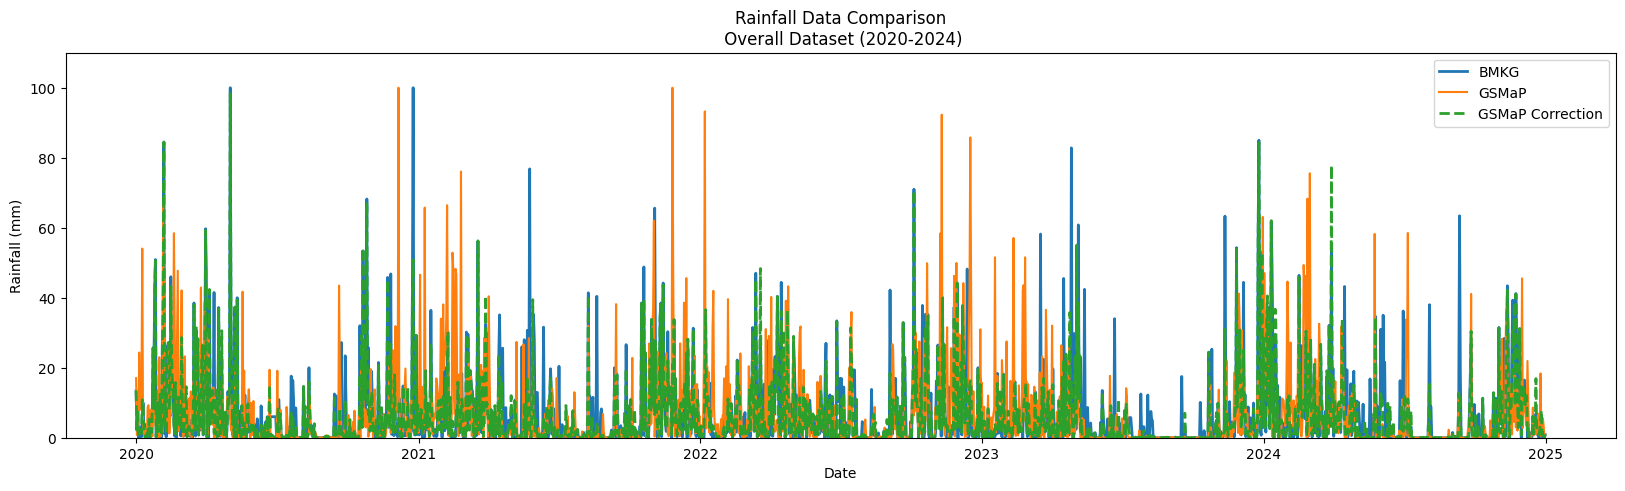

In [1298]:
plt.figure(figsize=(20,5))
plt.plot(df_all['DATE'], df_all['RR'], label='BMKG',linewidth=2)
plt.plot(df_all['DATE'], df_all['GSMaP'], label='GSMaP')
plt.plot(df_all['DATE'], df_all['Corrected Rainfall'], label='GSMaP Correction',linewidth=2,linestyle='--')
plt.title('Rainfall Data Comparison\n Overall Dataset (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,110)
plt.legend()
plt.show()

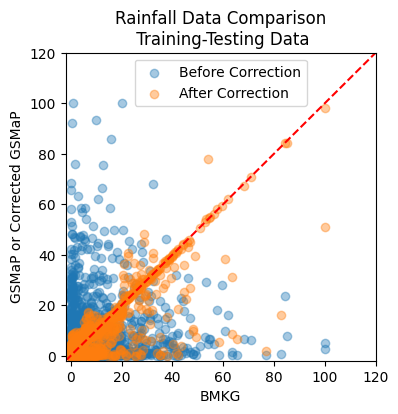

In [1297]:
plt.figure(figsize=(4,4))
plt.scatter(df_all['RR'], df_all['GSMaP'], label='Before Correction',alpha=0.4,)
plt.scatter(df_all['RR'], df_all['Corrected Rainfall'], label='After Correction',alpha=0.4,)
plt.plot([-2, 200], [-2, 200], color='red', linestyle='--')
plt.title('Rainfall Data Comparison\n Training-Testing Data')
plt.xlabel('BMKG')
plt.ylabel('GSMaP or Corrected GSMaP')
plt.xlim(-2,120)
plt.ylim(-2,120)
plt.legend()
plt.show()

## **Chapter 5<br> Validating**

### **A. Importing Unseen Dataset (only 4 months in 2025)**

In [1273]:
raw_bmkg_2025 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/BMKG Klimatologi Bandung 2025.csv').dropna()
raw_gsmap_2025 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/GSMaP 2025 Rainfall Data.csv')

# Data Cleaning BMKG 2025 Dataset
raw_bmkg_2025['DATE'] = pd.to_datetime(raw_bmkg_2025['DATE'])
raw_bmkg_2025['RR'] = pd.to_numeric(raw_bmkg_2025['RR'], errors='coerce')

clean_bmkg_2025 = raw_bmkg_2025.copy()
# Replace '8888', '9999', and '-' with NaN
clean_bmkg_2025['RR'] = clean_bmkg_2025['RR'].replace([8888, 9999,"-"], np.nan)

# Apply a moving average (MA) 7 to fill NaN values
clean_bmkg_2025['RR'] = clean_bmkg_2025['RR'].fillna(clean_bmkg_2025['RR'].rolling(window=7, min_periods=1).mean())

print(clean_bmkg_2025.info())

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    120 non-null    datetime64[ns]
 1   RR      119 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB
None


In [1274]:
# Data Cleaning GSMaP 2025 Dataset
raw_gsmap_2025['Date'] = pd.to_datetime(raw_gsmap_2025['Date'])
raw_gsmap_2025 = raw_gsmap_2025.rename(columns={'gsmap': 'GSMaP'})
clean_gsmap_2025 = raw_gsmap_2025.copy()

clean_gsmap_2025.info()
# Data is already cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    120 non-null    datetime64[ns]
 1   GSMaP   120 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [1275]:
df_2025 = pd.merge(clean_gsmap_2025, clean_bmkg_2025, left_on='Date', right_on='DATE', how='inner').fillna(0)
add_features(df_2025)

,Date,GSMaP,DATE,RR,GSMaP_lag1,Day_of_Year,Correction_Factor,Correction_Type,RR_Intensity_Cat
0,2025-01-01,3.02,2025-01-01,0.0,0.00,1,0.10,2,0
1,2025-01-02,0.26,2025-01-02,3.5,3.02,2,20.00,1,0
2,2025-01-03,3.46,2025-01-03,0.3,0.26,3,0.10,2,0
3,2025-01-04,6.49,2025-01-04,0.0,3.46,4,0.10,2,0
4,2025-01-05,10.91,2025-01-05,3.2,6.49,5,0.29,0,0
...,...,...,...,...,...,...,...,...,...
115,2025-04-26,2.87,2025-04-26,6.0,1.10,116,2.09,0,1
116,2025-04-27,0.03,2025-04-27,0.2,2.87,117,1.00,3,0
117,2025-04-28,0.02,2025-04-28,0.0,0.03,118,1.00,3,0
118,2025-04-29,0.03,2025-04-29,3.5,0.02,119,20.00,1,0


### **B. Applying Optimized XGBoost to Unseen Dataset**

In [1276]:
x_2025 = df_2025.drop(columns=['RR','DATE','Date','Correction_Factor'])
y_2025 = df_2025['Correction_Factor'].drop(columns=['DATE'])

x_scaled_2025 = scaler.fit_transform(x_2025)
x_scaled_2025 = pd.DataFrame(x_scaled_2025, columns=x_2025.columns)

y_scaled_2025 = scaler.fit_transform(y_2025.values.reshape(-1, 1))
y_scaled_2025 = pd.DataFrame(y_scaled_2025, columns=['Correction_Factor'])

In [1277]:
# Random Forest Regression

y_pred_xgb_2025 = model_xgb.predict(x_scaled_2025)

y_pred_xgb_2025_original_scale = scaler.inverse_transform(np.concatenate([y_pred_xgb_2025.reshape(-1,1), x_scaled_2025], axis=1))[:, 0]
df_2025['Correction Factor Model'] = y_pred_xgb_2025_original_scale.round(2)
df_2025['Corrected Rainfall'] = df_2025['GSMaP'] * df_2025['Correction Factor Model'].round(2)
df_2025['Corrected Rainfall'] = df_2025['Corrected Rainfall'].clip(lower=0)

df_2025 = df_2025.round(2)
df_2025

,Date,GSMaP,DATE,RR,GSMaP_lag1,Day_of_Year,Correction_Factor,Correction_Type,RR_Intensity_Cat,Correction Factor Model,Corrected Rainfall
0,2025-01-01,3.02,2025-01-01,0.0,0.00,1,0.10,2,0,0.16,0.48
1,2025-01-02,0.26,2025-01-02,3.5,3.02,2,20.00,1,0,19.96,5.09
2,2025-01-03,3.46,2025-01-03,0.3,0.26,3,0.10,2,0,0.23,0.80
3,2025-01-04,6.49,2025-01-04,0.0,3.46,4,0.10,2,0,0.10,0.65
4,2025-01-05,10.91,2025-01-05,3.2,6.49,5,0.29,0,0,0.14,1.53
...,...,...,...,...,...,...,...,...,...,...,...
115,2025-04-26,2.87,2025-04-26,6.0,1.10,116,2.09,0,1,4.07,11.69
116,2025-04-27,0.03,2025-04-27,0.2,2.87,117,1.00,3,0,1.01,0.03
117,2025-04-28,0.02,2025-04-28,0.0,0.03,118,1.00,3,0,1.01,0.02
118,2025-04-29,0.03,2025-04-29,3.5,0.02,119,20.00,1,0,19.99,0.52


### **C. Evaluation of Unseen Dataset**

In [1278]:
#Before Correction
rmse_xgb_2025_before = np.round(root_mean_squared_error(df_2025['RR'], df_2025['GSMaP']),3)
mae_xgb_2025_before = np.round(mean_absolute_error(df_2025['RR'],df_2025['GSMaP']),3)
correlation_2025_before = np.round(np.corrcoef( df_2025['RR'],df_2025['GSMaP'])[0, 1],3)

print('Validation Result\n')
print(f"Before Correction")
print(f"RMSE: {rmse_xgb_2025_before}")
print(f"MAE: {mae_xgb_2025_before}")
print(f"Correlation: {correlation_2025_before}")

# After Correction
rmse_xgb_2025_after = np.round(root_mean_squared_error(df_2025['RR'], df_2025['Corrected Rainfall']),3)
mae_xgb_2025_after = np.round(mean_absolute_error(df_2025['RR'],df_2025['Corrected Rainfall']),3)
correlation_2025_after = np.round(np.corrcoef( df_2025['RR'],df_2025['Corrected Rainfall'])[0, 1],3)

print(f"\nAfter Correction")
print(f"RMSE: {rmse_xgb_2025_after}")
print(f"MAE: {mae_xgb_2025_after}")
print(f"Correlation: {correlation_2025_after}")

Validation Result

Before Correction
RMSE: 18.773
MAE: 11.965
Correlation: 0.014

After Correction
RMSE: 8.87
MAE: 3.661
Correlation: 0.754


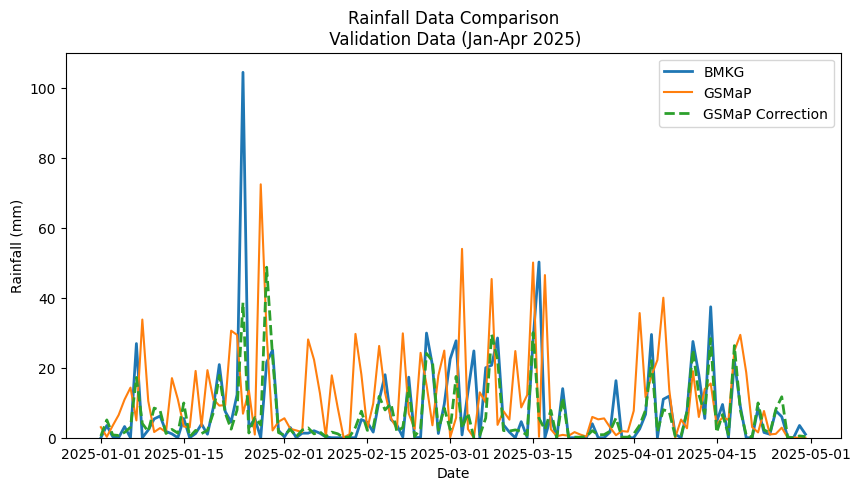

In [1299]:
plt.figure(figsize=(10,5))
plt.plot(df_2025['DATE'], df_2025['RR'], label='BMKG',linewidth=2)
plt.plot(df_2025['DATE'], df_2025['GSMaP'], label='GSMaP')
plt.plot(df_2025['DATE'], df_2025['Corrected Rainfall'], label='GSMaP Correction',linewidth=2,linestyle='--')
plt.title('Rainfall Data Comparison\n Validation Data (Jan-Apr 2025)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,110)
plt.legend()
plt.show()

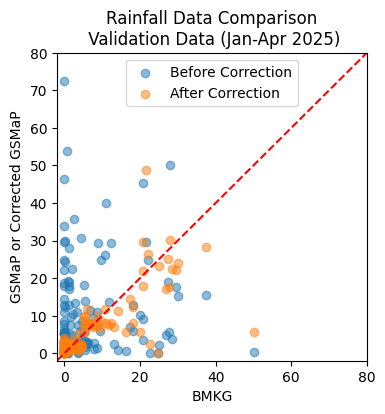

In [1300]:
plt.figure(figsize=(4,4))
plt.scatter(df_2025['RR'], df_2025['GSMaP'], label='Before Correction',alpha=0.5,)
plt.scatter(df_2025['RR'], df_2025['Corrected Rainfall'], label='After Correction',alpha=0.5,)
plt.plot([-2, 100], [-2, 100], color='red', linestyle='--')
plt.title('Rainfall Data Comparison\n Validation Data (Jan-Apr 2025)')
plt.xlabel('BMKG')
plt.ylabel('GSMaP or Corrected GSMaP')
plt.xlim(-2,80)
plt.ylim(-2,80)
plt.legend()
plt.show()

<a href="https://www.linkedin.com/in/iqbalfauzanh/"><img src="https://img.shields.io/badge/-© 2025 Iqbal Fauzan Herlambang-417DAC?style=for-the-badge&logoColor=white"/></a>